# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Well, ICA discovers underlying statistically independent causes.  So, while it is the case that our data consists of the yearly net price of all products in various categories ordered by stores, there may be independent trends consisting of combinations of the categories that get revealed, corresponding to maybe a part of a store or type of store or independent variance attributable to geographic position. In the context of our lesson, we may find a component that corresponds to either small stores or some shared property of small stores that might help us solve our dilemma.  PCA will find the best way to describe many features in terms of lesser amounts of new features which are rotations of the old ones.  So it'll tell me what, in essence, a store is like, and the best first correction to that.  

###PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

It drops off quite quickly after the first two components, by 82 percent, then about 50 percent on average afterwards.  The cliff after the second principal component seems to suggest the second PC a good cutoff point; the components afterwards aren't explaining very much variance. 

**3)** What do the dimensions seem to represent? How can you use this information?

The first dimension, at least, can be interpreted as the typical store ratio of orders.  What I mean by that is that if we consider all possible feature vectors, this is the one that gets closest to describing the data by itself, up to a constant multiplier. The first two are then just the two feature vectors that do as above.  We can use this information to simplify the data we use other learning algorithms on, since most of the information si going to be contained in the linear combination of these first two feature vectors, the last 4 are only minor corrections.

That's what PCA is in the abstract, but is there a concrete interpretation of the specific component vectors we obtained?  Well, the first PCA component consists almost entirely of the Fresh category, along with positive (same sign as Fresh) amounts of the other categories.  The second component, on the other hand, contains mostly Grocery, Milk and Detergents (in that order of importance) , with a small anti-correlation with Fresh. It's a bit challenging to concretely interpret these vectors since we don't have much information on what products exactly fall under the categories such as "Fresh" (What belongs to "Fresh" as opposed to "Grocery"?).  

Nonetheless, the combination exhibited in the second PCA component does seem to suggest a sort of small corner-store pattern of orders, whereas the combination in the first component could be moreso the tendencies of the bigger actors, maybe large restaurants that need a steady stream of fresh ingredients but not much else. 

###ICA

In [3]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

# Adjusting data to have zero mean

data_mean = np.mean(data)
print data_mean

data_std = np.std(data)
print data_std

adjusted_data = data - data_mean

# Just making sure we did this right...
np.testing.assert_allclose(np.mean(adjusted_data) , np.zeros(6), atol=1.0e-10)

ica = FastICA()
source_data = ica.fit_transform(adjusted_data)
components = ica.components_

print "\n -ICA Component Matrix- "
print components 

source_data_std = np.std(source_data)
print source_data_std

np.testing.assert_allclose(np.mean(source_data), np.zeros(6), atol=1.0e-10)

# Scale the source data to the variance and mean of the original data
source_data /= source_data_std
source_data *= data_std
source_data += data_mean

print "\n -Rescaled Source Data- "
print source_data

print "\n -Rescaled ICA Component Matrix- "
print components * 10000000

print "\n -Rescaled ICA Mixing Matrix- "
print ica.mixing_ / 1000

Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64
Fresh               12632.948725
Milk                 7371.985612
Grocery              9492.357638
Frozen               4849.153520
Detergents_Paper     4762.433350
Delicatessen         2816.899449
dtype: float64

 -ICA Component Matrix- 
[[ -3.93405866e-07  -3.06181221e-07  -7.14345867e-07  -5.24554383e-07
    6.16833874e-07   1.82163867e-05]
 [ -8.57524699e-07  -2.14340743e-07   8.98562982e-07   1.11479738e-05
   -6.25909343e-07  -5.93330741e-06]
 [ -2.42005515e-07   2.92777434e-06   1.12215836e-05  -1.52516105e-06
   -2.78217727e-05  -5.85605497e-06]
 [  1.47782655e-07  -6.45187671e-06   9.51384382e-06   2.46358294e-07
   -4.86318556e-06   1.60075071e-06]
 [  3.43900204e-07   7.43447052e-06  -1.79682197e-06  -1.33569155e-07
    2.68369510e-06  -5.56605855e-06]
 [  3.9717510

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

-Warning-
The ICA Components are numbered here as they are arranged in my notes, not necessarily as they are here in the printout above
Make sure to rearrange the descriptions below as needed before submission

1) This ICA component admits a very simple explanation; it consists almost entirely of Delicatessen with trivial amounts of the other categories.  It most likely corresponds to a traditional Delicatessen section of a store.
2) One could possibly interpret this as  the delivery of frozen meat; in which case it would make sense that it's in opposition to deli meat, since if, say, a restaurant orders frozen meat it's unlikely to order the fresh version as well. 
3) This component is dominated by the Paper category, but intrestingly enough if you look at the source data and the net money spent by each customer, it has almost no correlation with the amount spent per customer at all.  It's completely independent of whether a business orders a lot per year (presumalbly, is large) or whether it orders very little (is small).  Seeing as our aim is to discern the habits of our smaller customers, this component isn't very useful.
4) This corresponds very neatly with the Fresh category from before, hence I'll just interpret it as such and not as a new fundamental feature.
5) This component corresponds mostly to the Milk category from before, but it interestingly enough anti-correlates with both Grocery and Deli but has a slight correlation with the Detergents and Paper category.   
6) 


If these ICA vectors corresponded to specific objects or properties, then we could use them as an alternate basis for our data in terms of these more basic objects and properties instead of in terms of the original categories.  However, I've unfortunately not been able to glean much from them, besides the fact that ICA5 is almost completely independent of how big the customer is.  We could, conceivably, use the source data with ICA5 removed as the new data to then do other analysis on, although it wouldn't fit in considering the predetermined structure of this assignment.  But yes, it would be interesting to run PCA on just the 5 ICA components, then compose the two transformations to describe the two largest PCA components in terms of the original categories, and analyze this new data.


##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

An advantage of the Gaussian Mixture method is that since we're assuming our data is generated by a mixture of Gaussian distributions, every data point has some probability that it belongs to one of the Gaussians.  It doesn't have a hard cutoff, and since in this case I don't feel like I know very much about the data, I would rather see each point have a component belonging to each Gaussian instead of a hard assignment to a particular mean value.  Gaussian Mixture models can have pathological convergence problems, but those can usually be solved by proper choice of parameters and preprocessing of data.  

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [6]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca2 = PCA(n_components=2, copy=True)
reduced_data = pca2.fit_transform(source_data[:,[0,1,3,4,5]])
print reduced_data[:10]  # print upto 10 elements

[[  -847.70853259   5006.02329659]
 [  1345.23402893   1781.29315829]
 [ 31094.94291327   6397.05099605]
 [  1366.40807663  -5198.92975007]
 [ 16437.73235651   3297.35188338]
 [   404.97081294   4105.71222575]
 [ -3945.04044056   3660.39931069]
 [  5542.50103766   2597.21706959]
 [ -2426.30933328   3111.91455029]
 [  1901.36431197   2125.27094332]]


In [15]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

clusters = GMM(n_components=3)
clusters.fit(reduced_data)
print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [19]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [17]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.means_
print centroids

[[  -2431.53224121   -5085.15723848]
 [ 210986.53838805  -12489.94354705]
 [    343.46482411    2188.44215493]]


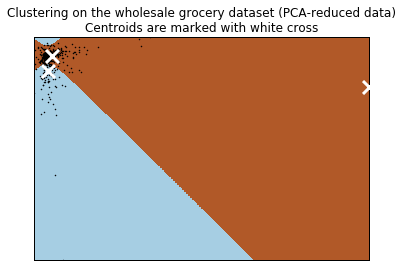

In [18]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

**10)** How would you use that data to help you predict future customer needs?

Answer: 